# <center> Machine learning Miniproject
## <center> By Mariem Maazoun and Maxime Lehmann

### Project Introduction :

Near-infrared spectroscopy is a method to detect the presence and even the quantity of cetrain chemical compounds by analysing the near-infrared reagion of the electomagnegtic spectrum. This method is far faster and cheaper than lab methods like chromatography and today is the most widely used analysis by law enforcement when they need to ascertain whether a substance contains illegal drug. Each differant compound having a different absorption spectrum when can differentiate the chemical compounds by their spectrum. In this project we will be given for each sample the near-infrared spectrum, the device used for the measurement, the form of the substance sample and whether the sample was measured with direct contact and through a glass. In the train set we will also have the heroin purity of the sample but not for the test set, our goal is to be able to compute the heroin purity of the test sample based mainly on the infrared spectrum using maching learning tools.

In [1]:
import sys
!{sys.executable} -m pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from torch.utils.data import DataLoader  , TensorDataset
import optuna
from skorch.helper import DataFrameTransformer
import torch.nn.functional as F
from scipy.signal import savgol_filter
from scipy.stats import zscore

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim 
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import sklearn
import skorch
from skorch import NeuralNetRegressor
from bayes_opt import BayesianOptimization
from scipy.signal import savgol_filter
from scipy.stats import zscore
import torch 
import warnings

# For reproductibility
seed = 42

## 1. Data Inspection : 
Loading, exploration and visualisation of the data

In [5]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

In [5]:
df_train.shape

(1300, 131)

In [6]:
df_test.shape

(608, 130)

In [7]:
df_train.head()

,sample_name,device_serial,substance_form_display,measure_type_display,prod_substance,PURITY,908.1,914.3,920.5,926.7,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,11140009,M1-1000112,Homogenized Powder,Direct contact,Heroin,58.500000,0.044734,0.042720,0.041361,0.040055,...,0.003972,0.007906,0.012490,0.018123,0.025070,0.033235,0.042502,0.052237,0.061383,0.068823
1,22.0401-P002.02,M1-1000109,Non homogenized powder,Direct contact,Heroin,18.600000,0.063695,0.056980,0.050080,0.043339,...,0.093002,0.099668,0.108805,0.117120,0.121947,0.125137,0.128688,0.133501,0.138187,0.140248
2,22.0117-P001.02,M1-1000100,Non homogenized powder,Direct contact,Heroin,19.881719,0.050358,0.044910,0.039148,0.033730,...,0.083369,0.090485,0.100462,0.109033,0.113411,0.117053,0.121665,0.128366,0.134636,0.136961
3,20.0163-P009,N1-00196,Unspecified,Direct contact,Heroin,52.500000,0.525050,0.520434,0.517187,0.516377,...,0.357223,0.370060,0.386062,0.404460,0.425567,0.450527,0.479066,0.508943,0.539349,0.564486
4,19.0286-P005,N1-00196,Unspecified,Direct contact,Heroin,48.900000,0.479365,0.467401,0.456680,0.446148,...,0.350973,0.366094,0.384536,0.405034,0.426582,0.450564,0.477045,0.504142,0.531764,0.553650


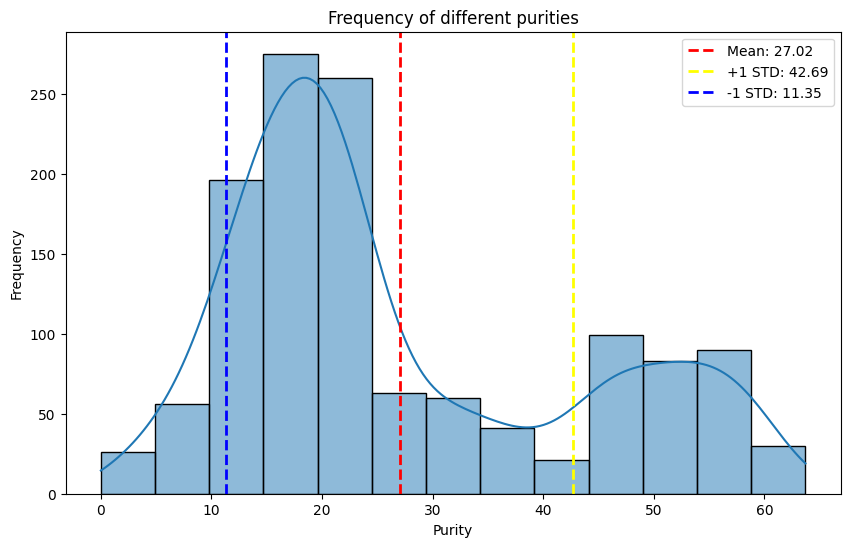

In [8]:
#Purity frequency
mean_rt = df_train['PURITY'].mean()
std_rt = df_train['PURITY'].std()

plt.figure(figsize=(10, 6)) 
sns.histplot(x='PURITY', kde=True, binwidth=5, data=df_train)

# Add a vertical line for the mean
plt.axvline(mean_rt, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_rt:.2f}')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(mean_rt + std_rt, color='yellow', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean_rt + std_rt:.2f}')
plt.axvline(mean_rt - std_rt, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {mean_rt - std_rt:.2f}')

plt.title('Frequency of different purities')
plt.xlabel('Purity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("Graphs/frequency_of_PURITY")

#### Skewness in purity values: 
Since the data is skewed, machine learning models may benefit from transformations (such as a log or square root transformation) to handle the skewness and improve model performance. Target Distribution: The concentration of data in the mid-range suggests that most cases involve moderate purity levels, with fewer samples representing very low or very high purity.

### Comparasion by device used

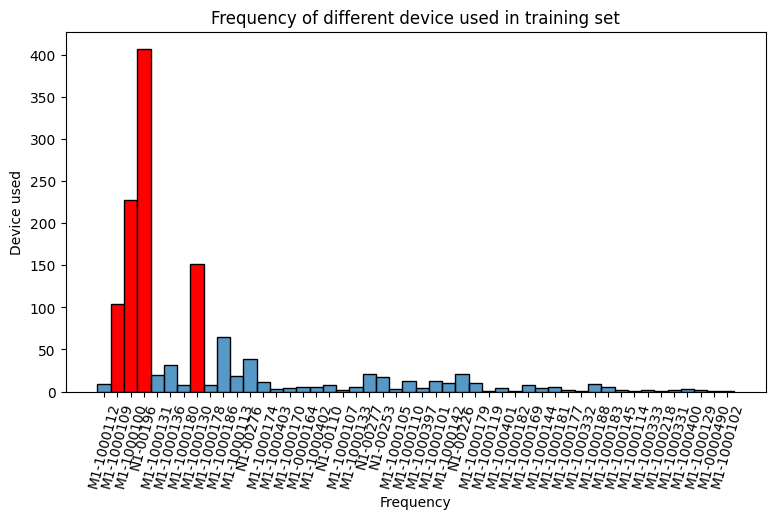

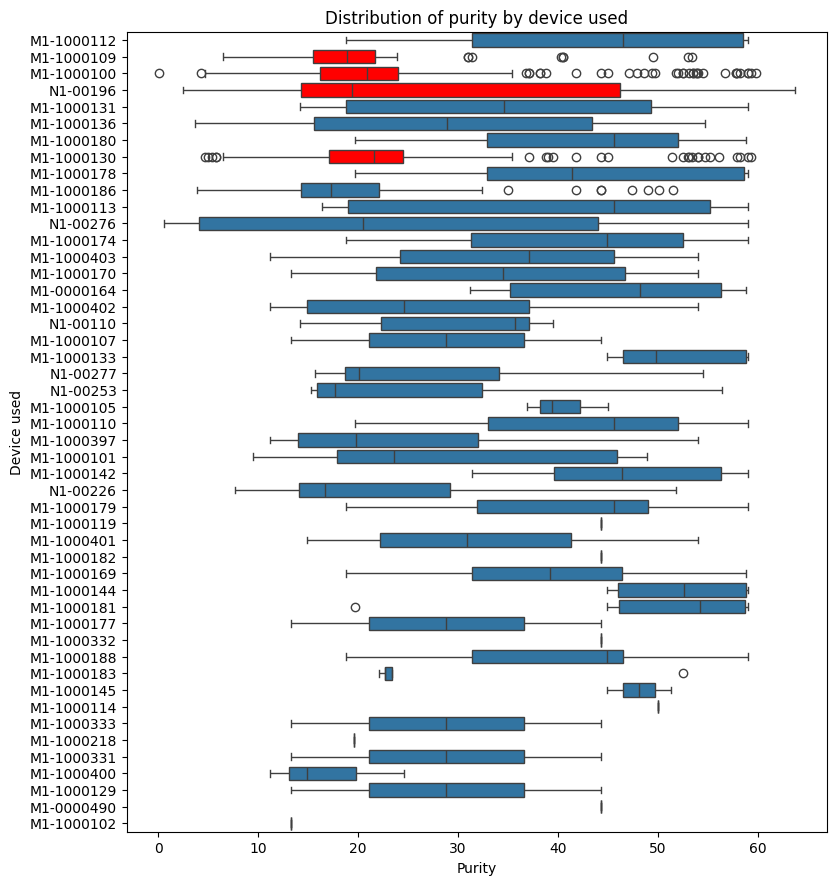

In [9]:
#Frequency of value
plt.figure(figsize=(10, 6)) 
ax = sns.histplot(x="device_serial", kde=False, data=df_train)
ax.patches[1].set_facecolor('red')
ax.patches[2].set_facecolor('red')
ax.patches[3].set_facecolor('red')
ax.patches[7].set_facecolor('red')
plt.title('Frequency of different device used in training set')
plt.xlabel('Frequency')
plt.ylabel('Device used')
plt.xticks(rotation=75)
plt.subplots_adjust(left=0.2, bottom=0.3, right=0.9, top=0.9)
plt.savefig("Graphs/frenquency_of_device_used")

# Purity by device used
plt.figure(figsize=(10, 10)) 
ax = sns.boxplot(x='PURITY', y="device_serial", data=df_train)
ax.patches[1].set_facecolor('red')
ax.patches[2].set_facecolor('red')
ax.patches[3].set_facecolor('red')
ax.patches[7].set_facecolor('red')
plt.title('Distribution of purity by device used')
plt.xlabel('Purity')
plt.ylabel("Device used")
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.9)
plt.savefig("Graphs/distribution_by_device_used" )

#### Most used device in training set : 
The first thing we see when looking a the frequency of the device used is that some of them are used greatly more than others, the four most used were highlighted in red.  
When looking at the Distribution of Purity by device used we see that different device have different mean and deviation but there doesn't seem to be any outliers.  
Another thing to note is that 3 of the most used device have a mean of about 20 for purity, lower than the mean of the test sample of 27.  

In [10]:
#Four most used devices
df_train_M1_1000109= df_train[df_train.device_serial == "M1-1000109"]
df_train_M1_1000100 = df_train[df_train.device_serial == "M1-1000100"]
df_train_N1_00196 = df_train[df_train.device_serial == "N1-00196"]
df_train_M1_1000130 = df_train[df_train.device_serial == "M1-1000130"]
df_train_four_combined = pd.concat([df_train_M1_1000109,df_train_M1_1000100,df_train_N1_00196,df_train_M1_1000130])

print("There are {} entries for the M1-1000109 device. \nThere are {} entries for the M1-1000100 device. \nThere are {} entries for the N1-00196 device. \nThere are {} entries for the M1-1000130 device.".format(
    len(df_train_M1_1000109),
    len(df_train_M1_1000100),
    len(df_train_N1_00196),
    len(df_train_M1_1000130)))

print("The total of entries among these four device combined is {} which is {} percent of the total training set".format(
    len(df_train_four_combined), len(df_train_four_combined)/len(df_train)*100
))

There are 104 entries for the M1-1000109 device. 
There are 227 entries for the M1-1000100 device. 
There are 407 entries for the N1-00196 device. 
There are 152 entries for the M1-1000130 device.
The total of entries among these four device combined is 890 which is 68.46153846153847 percent of the total training set


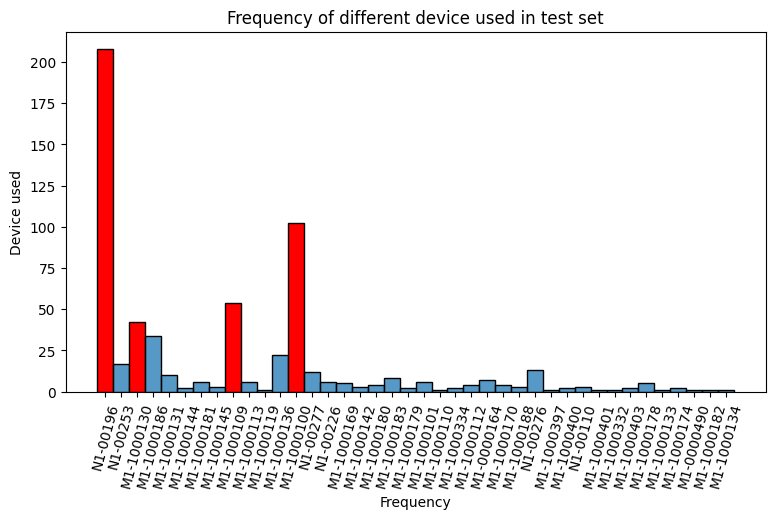

In [11]:
#Frequency of value
plt.figure(figsize=(10, 6)) 
ax = sns.histplot(x="device_serial", kde=False, data=df_test)
ax.patches[0].set_facecolor('red')
ax.patches[2].set_facecolor('red')
ax.patches[8].set_facecolor('red')
ax.patches[12].set_facecolor('red')
plt.title('Frequency of different device used in test set')
plt.xlabel('Frequency')
plt.ylabel('Device used')
plt.xticks(rotation=75)
plt.subplots_adjust(left=0.2, bottom=0.3, right=0.9, top=0.9)
plt.savefig("Graphs/frenquency_of_device_used")

In [12]:
#Four most used devices in test set
df_test_M1_1000109= df_test[df_test.device_serial == "M1-1000109"]
df_test_M1_1000100 = df_test[df_test.device_serial == "M1-1000100"]
df_test_N1_00196 = df_test[df_test.device_serial == "N1-00196"]
df_test_M1_1000130 = df_test[df_test.device_serial == "M1-1000130"]
df_test_four_combined = df_test_M1_1000109+df_test_M1_1000100+df_test_N1_00196+df_test_M1_1000130

print("There are {} entries for the M1-1000109 device. \nThere are {} entries for the M1-1000100 device. \nThere are {} entries for the N1-00196 device. \nThere are {} entries for the M1-1000130 device.".format(
    len(df_test_M1_1000109),
    len(df_test_M1_1000100),
    len(df_test_N1_00196),
    len(df_test_M1_1000130)))

print("The total of entries among these four device combined is {} which is {} percent of the total test set".format(
    len(df_test_four_combined), len(df_test_four_combined)/len(df_test)*100
))

There are 54 entries for the M1-1000109 device. 
There are 102 entries for the M1-1000100 device. 
There are 208 entries for the N1-00196 device. 
There are 42 entries for the M1-1000130 device.
The total of entries among these four device combined is 406 which is 66.77631578947368 percent of the total test set


#### Most used device in test set : 
It seems that the four most used devices in the training set are also the four most used devices in the test set, and their total percentage remains similar. If the device used brings a skew to the data we can expect a similar skew in the test set.

### Other Columns

In [13]:
#Counting other variables
count_train_substance_form_display = df_train.substance_form_display.value_counts().to_frame()
count_train_measure_type_display = df_train.measure_type_display.value_counts().to_frame()
count_train_prod_substance = df_train.prod_substance.value_counts().to_frame()
count_test_substance_form_display = df_test.substance_form_display.value_counts().to_frame()
count_test_measure_type_display = df_test.measure_type_display.value_counts().to_frame()
count_test_prod_substance = df_test.prod_substance.value_counts().to_frame()

In [14]:
#Product substance in train set
count_train_prod_substance.head()

,count
prod_substance,
Heroin,1300


In [15]:
#Product substance in test set
count_test_prod_substance.head()

,count
prod_substance,
Heroin,608


#### Product substance : 
We can see the the prod_substance column doesnt have any useful information, we can ignore this column.

In [16]:
#Measure type in train set
count_train_measure_type_display.head()

,count
measure_type_display,
Direct contact,1296
Transparent glass,4


In [17]:
#Measure type in test set
count_test_measure_type_display.head()

,count
measure_type_display,
Direct contact,606
Transparent glass,2


#### Measure type : 
The measure_type_display column is overwhelmingly composed of direct contact entries in both set. it will probably be best to start by ignoring this column too. 

In [18]:
#Substance form in train set
count_train_substance_form_display.head()

,count
substance_form_display,
Homogenized Powder,627
Unspecified,459
Non homogenized powder,214


In [19]:
#Substance form in test set
count_test_substance_form_display.head()

,count
substance_form_display,
Homogenized Powder,291
Unspecified,227
Non homogenized powder,89
Brick,1


#### Substance form : 
This column is more tricky, in our training set the heroin is tested in two forms : homogenized powder and non homogenized powder. We don't know the form for a substanstiable amout of entries. We could try to use this entry has a categorical variable, but we have to think about how to treat the unspecified value.
We could try to use it has a third category for now. 

For the Brick entry in the test set we have no value for it in the training set, so if we do decide to use a categorical variable for this entry the simplest solution for it would be to compute it as an unspecified value. 

## 2. Preprocessing

For preprocessing, we remove the unused columns and filter the spectrum with random forest keeping only the ones with an importance greater than a threshold. The threshold was obtained by trial and error. 

In [6]:
def rand_forest(df_train, thresh):
    #Select variables with importance > thresh
    
    X = df_train.iloc[:, 6:]
    y = df_train[['PURITY']].squeeze()

    rf = RandomForestRegressor(n_estimators=100, random_state=seed) 
    rf.fit(X, y)

    sfm = SelectFromModel(rf, threshold=thresh)

    variables_indices = ~sfm.get_support()

    removed_columns_names = X.columns[variables_indices]
   
    return removed_columns_names

In [7]:
def preprocessing(df_train, df_test, unwanted, thresh):

    #we use random forest to remove unwanted spectrum
    removed_columns_names = rand_forest(df_train, thresh)
    
    df_train = df_train.drop(columns=removed_columns_names)
    df_test = df_test.drop(columns=removed_columns_names)
    
    #remove unwwanted columns
    df_train = df_train.drop(unwanted, axis=1)
    df_test = df_test.drop(unwanted, axis=1)

    return df_train, df_test  

In [8]:
tresh = 0.03792690190732246
unwanted = ["prod_substance", "measure_type_display", "substance_form_display", "sample_name", "device_serial"]
df_preprocess_train, df_preprocess_test = preprocessing(df_train, df_test, unwanted, tresh) 

In [9]:
df_preprocess_train.columns

Index(['PURITY', '963.8', '1205.4', '1601.9', '1608.1', '1626.6', '1632.8'], dtype='object')

### Neural Network Preprocessing

In [ ]:
# since neural network work better with bigger amount of data m we try to set the threshhold for getting important feature as lows as possible so we get high proportion of features.
df_preprocess_train, df_preprocess_test = preprocessing(df_train, df_test, unwanted, thresh = 0.0001) 

X = df_preprocess_train.iloc[:, 1:]
y = df_preprocess_train['PURITY']

In [ ]:
# preprocess for traing data - applying the savgol_filter  on data 

spectrum_filtered = pd.DataFrame(savgol_filter(X, 7, 3, deriv = 2, axis = 1))
spectrum_filtered_standardized = zscore(spectrum_filtered, axis = 1)
X = spectrum_filtered_standardized.copy()

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y , dtype=torch.float32).reshape(-1, 1)

# preprocess spectrum for test data 

test = pd.DataFrame(savgol_filter(df_preprocess_test, 7, 3, deriv = 2, axis = 1))
test = zscore(test, axis = 1)


X_tensor = torch.tensor(X.values, dtype=torch.float32)
test = torch.tensor(test.values, dtype=torch.float32)

## 3. Linear Model

### Bridge and Lasso

For the Linear methods part, we performed a Bayes Ridge and a Lasso regression. For both methods we coded a generic Bayesian Optimization Function which purpose is to automate hyper parameter tuning process using Bayesian Optimisation while performin a cross-validation on the model using cross_val_score and returning the mean score. We see that the Byes Ridge model performs better than the Lasso

In [11]:
X = df_preprocess_train.iloc[:, 1:]
y = df_preprocess_train['PURITY']

#Split the train set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define a custom RMSE scorer
def rmse(y_true, y_pred):
    """Calculates the Root Mean Squared Error (RMSE)."""
    return ((y_true - y_pred) ** 2).mean() ** 0.5

In [25]:
def optimize_model(model_class, param_bounds, model_params, cv_params):
    """
    Optimizes hyperparameters for a given model using Bayesian Optimization.
    
    Parameters:
    - model_class: The class of the model (e.g., BayesianRidge).
    - param_bounds: Dictionary specifying the hyperparameter search space.
    - model_params: Fixed parameters for the model.
    - cv_params: Parameters for cross-validation (e.g., X, y, cv).
    
    Returns:
    - Best parameters found during optimization.
    """
    def cv_score(**params):
        """Performs cross-validation and returns the mean score."""
        # Initialize the model with fixed and optimized parameters
        model = model_class(**{**model_params, **params})
        # Perform cross-validation
        cv_score = cross_val_score(model, **cv_params)
        return np.mean(cv_score)

    # Initialize Bayesian optimizer
    optimizer = BayesianOptimization(f=cv_score, pbounds=param_bounds, random_state=42)
    optimizer.maximize(init_points=10, n_iter=30)  # Run optimization
    return optimizer.max['params']  # Return best parameters


# Cross-validation parameters
cv_params = {
    'X': X_train,  # Training features
    'y': y_train,  # Training labels
    'cv': 5,       # 5-fold cross-validation
    'scoring': 'neg_mean_squared_error'  # Scoring metric
}

In [26]:
# Define hyperparameter bounds for Bayesian Ridge
params_bayesian_ridge = {
    'alpha_1': (1e-10, 1e-3),
    'alpha_2': (1e-10, 1e-3),
    'lambda_1': (1e-10, 1e-3),
    'lambda_2': (1e-10, 1e-3)
}
# Perform Bayesian Optimization for Bayesian Ridge
best_params_bayesian_ridge = optimize_model(BayesianRidge, params_bayesian_ridge, {}, cv_params)
print("Best parameters for Bayesian Ridge: ", best_params_bayesian_ridge)

model_bayesian_ridge = BayesianRidge(**best_params_bayesian_ridge)
model_bayesian_ridge.fit(X_train, y_train)
bayes_ridge_score = cross_val_score(model_bayesian_ridge, X_train, y_train, scoring=make_scorer(rmse), cv=5)
print(bayes_ridge_score)


|   iter    |  target   |  alpha_1  |  alpha_2  | lambda_1  | lambda_2  |
-------------------------------------------------------------------------
| 1         | -79.78    | 0.0003745 | 0.0009507 | 0.000732  | 0.0005987 |
| 2         | -79.78    | 0.000156  | 0.000156  | 5.808e-05 | 0.0008662 |
| 3         | -79.78    | 0.0006011 | 0.0007081 | 2.058e-05 | 0.0009699 |
| 4         | -79.78    | 0.0008324 | 0.0002123 | 0.0001818 | 0.0001834 |


/home/.local/lib/python3.12/site-packages/bayes_opt/target_space.py:344: UserWarning: You're attempting to register an np.ndarray. Currently, the optimizer internally sorts parameters by key and expects any registered array to respect this order. In future versions this behaviour will change and the order as given by the pbounds dictionary will be used. If you wish to retain sorted parameters, please manually sort your pbounds dictionary before constructing the optimizer.
  warn(msg, stacklevel=1)


| 5         | -79.78    | 0.0003042 | 0.0005248 | 0.0004319 | 0.0002912 |
| 6         | -79.78    | 0.0006119 | 0.0001395 | 0.0002921 | 0.0003664 |
| 7         | -79.78    | 0.0004561 | 0.0007852 | 0.0001997 | 0.0005142 |
| 8         | -79.78    | 0.0005924 | 4.645e-05 | 0.0006075 | 0.0001705 |
| 9         | -79.78    | 6.505e-05 | 0.0009489 | 0.0009656 | 0.0008084 |
| 10        | -79.78    | 0.0003046 | 9.767e-05 | 0.0006842 | 0.0004402 |
| 11        | -79.78    | 0.0009955 | 0.0001189 | 1.495e-05 | 0.00089   |
| 12        | -79.78    | 0.0009918 | 0.0001086 | 1.002e-05 | 0.0008708 |
| 13        | -79.78    | 0.0009879 | 0.0008514 | 5.214e-06 | 0.0005752 |
| 14        | -79.78    | 2.248e-05 | 5.575e-05 | 9.802e-07 | 3.23e-05  |
| 15        | -79.78    | 3.486e-05 | 0.0009322 | 9.149e-07 | 8.179e-06 |
| 16        | -79.78    | 0.0008469 | 0.0009022 | 1.057e-06 | 7.37e-05  |
| 17        | -79.78    | 0.0005598 | 0.0004018 | 1.65e-07  | 0.0005588 |
| 18        | -79.78    | 2.085e-05 | 

In [27]:
#fit for Lasso
# Ignore non-convergence warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Hyperparameter bounds for Lasso Regression
params_lasso = {'alpha': (1e-4, 1e-1)}

# Optimize Lasso Regression
best_params_lasso = optimize_model(Lasso, params_lasso, {}, cv_params)
print("Best parameters for Lasso: ", best_params_lasso)

# Train the Lasso model with the best parameters
model_lasso = Lasso(**best_params_lasso, max_iter=1000)
model_lasso.fit(X_train, y_train)


# Make predictions and evaluate the model on the test set
#y_pred_lasso = model_lasso.predict(X_test)
#final_rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_score = cross_val_score(model_lasso, X_train, y_train, scoring=make_scorer(rmse), cv=5)
print(lasso_score)

#print("Final Test RMSE for Lasso:", final_rmse_lasso)

|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | -108.0    | 0.03752   |
| 2         | -112.1    | 0.09508   |
| 3         | -110.1    | 0.07323   |
| 4         | -109.2    | 0.05991   |


/home/.local/lib/python3.12/site-packages/bayes_opt/target_space.py:344: UserWarning: You're attempting to register an np.ndarray. Currently, the optimizer internally sorts parameters by key and expects any registered array to respect this order. In future versions this behaviour will change and the order as given by the pbounds dictionary will be used. If you wish to retain sorted parameters, please manually sort your pbounds dictionary before constructing the optimizer.
  warn(msg, stacklevel=1)


| 5         | -95.82    | 0.01569   |
| 6         | -95.82    | 0.01568   |
| 7         | -87.27    | 0.005903  |
| 8         | -111.3    | 0.08663   |
| 9         | -109.2    | 0.06015   |
| 10        | -109.9    | 0.07084   |
| 11        | -83.82    | 0.0001    |
| 12        | -83.82    | 0.0001158 |
| 13        | -83.82    | 0.0001048 |
| 14        | -83.82    | 0.0001006 |
| 15        | -83.82    | 0.0001017 |
| 16        | -83.82    | 0.0001008 |
| 17        | -83.83    | 0.000127  |
| 18        | -83.82    | 0.000113  |
| 19        | -83.82    | 0.0001129 |
| 20        | -83.82    | 0.0001029 |
| 21        | -83.82    | 0.0001098 |
| 22        | -83.82    | 0.0001028 |
| 23        | -83.82    | 0.0001028 |
| 24        | -83.82    | 0.0001037 |
| 25        | -83.82    | 0.0001016 |
| 26        | -83.82    | 0.0001007 |
| 27        | -83.82    | 0.0001007 |
| 28        | -83.82    | 0.0001005 |
| 29        | -83.82    | 0.000104  |
| 30        | -83.82    | 0.0001146 |
| 31        

We see that ridge regression is more effective than Lasso

## 4. Non-Linear Model

### Random Forest 

We tried to perform a  hyperparameter tuning for a Random Forest Regressor using GridSearchCV, with a focus on finding the optimal combination of hyperparameters to minimize RMSE, unfortunately it seems that we have failed since the RMSE after tuning is higher than before

In [12]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=seed)
random_forest.fit(X_train, y_train)
random_forest_score = cross_val_score(random_forest, X_train, y_train, scoring=make_scorer(rmse), cv=5)
print(random_forest_score)

[5.23723352 5.78523878 5.8549462  5.06889091 6.33270759]


In [13]:
y_pred = random_forest.predict(X_test)
RMSE = rmse(y_test, y_pred)  # Calculate RMSE
print(RMSE)

5.631665752526609

In [29]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [ 300 , 500 ],       # Number of trees
    'max_depth': [3, 4,  5 ,6 ],      # Maximum depth of the tree
    'min_samples_split': [ 7,10, 15 ],      # Minimum samples required to split an internal node
    'min_samples_leaf': [  4 , 7 ,10]       # Minimum samples required at a leaf node
     
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring= make_scorer(rmse),  # Use negative MSE as the scoring metric
    verbose=2,  # Display progress
    n_jobs=-1   # Use all available cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
RMSE = rmse(y_test, y_pred)  # Calculate RMSE
print("Test RMSE:", RMSE)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=7, n_estimators=300; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=7, n_estimators=300; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=   1.4s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=   1.4s
[CV] END max_depth=3, min_sample

### Neural Network
For the neural network we used the filter uploaded on Kaggle and trained a neural network with 3 hidden layers. We hypertuned it with different values of n neurons between 200 and 300, with decreasing the number of neurons with each layer tto capture high level of relationships at the end layer. We also added early stopping so that the model doesn't run infinitely .

In [32]:
# Neural Network with Four Hidden Layers
class Network(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4):
        """
        Initialize the neural network architecture.

        Args:
            input_size (int): Number of input features.
            hidden1 (int): Number of neurons in the first hidden layer.
            hidden2 (int): Number of neurons in the second hidden layer.
            hidden3 (int): Number of neurons in the third hidden layer.
            hidden4 (int): Number of neurons in the fourth hidden layer.
        """
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden1, hidden2)    # Second fully connected layer
        self.fc3 = nn.Linear(hidden2, hidden3)    # Third fully connected layer
        self.fc4 = nn.Linear(hidden3, hidden4)    # Fourth fully connected layer
        self.fc5 = nn.Linear(hidden4, 1)         # Output layer (single output)

    def forward(self, x):
        """
        Define the forward pass of the network using SELU activation.

        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        x = F.selu(self.fc1(x))  # Apply SELU activation to the first layer
        x = F.selu(self.fc2(x))  # Apply SELU activation to the second layer
        x = F.selu(self.fc3(x))  # Apply SELU activation to the third layer
        x = F.selu(self.fc4(x))  # Apply SELU activation to the fourth layer
        x = self.fc5(x)          # Output layer without activation (regression task)
        return x

# RMSE Loss Function
def rmse_loss(y_pred, y_true):
    """
    Compute Root Mean Squared Error (RMSE) loss.

    Args:
        y_pred (torch.Tensor): Predicted values.
        y_true (torch.Tensor): True values.
    Returns:
        torch.Tensor: RMSE loss value.
    """
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        """
        Initialize the EarlyStopping class to monitor validation loss.

        Args:
            patience (int): Number of epochs to wait before stopping if no improvement.
            min_delta (float): Minimum change in loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        """
        Update the early stopping mechanism based on validation loss.

        Args:
            val_loss (float): Current validation loss.
            model (torch.nn.Module): Current model instance.
        """
        if self.best_loss is None:
            # Initialize the best loss and save the current model state
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            # If validation loss has not improved enough, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                # Stop training if patience is exceeded
                self.early_stop = True
        else:
            # If validation loss improves, reset the counter and save the model
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

# Objective Function for Hyperparameter Tuning
def objective(trial):
    """
    Define the objective function for Optuna hyperparameter tuning.

    Args:
        trial (optuna.Trial): A single trial object for hyperparameter suggestions.
    Returns:
        float: Mean validation loss across folds.
    """
    # Suggest hyperparameters for the network and optimizer
    hidden1 = trial.suggest_int('hidden1', 200, 300)    # Number of neurons in the first hidden layer
    hidden2 = trial.suggest_int('hidden2', 100, 200)    # Number of neurons in the second hidden layer
    hidden3 = trial.suggest_int('hidden3', 50, 100)     # Number of neurons in the third hidden layer
    hidden4 = trial.suggest_int('hidden4', 25, 50)      # Number of neurons in the fourth hidden layer
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Learning rate for the optimizer

    # Initialize the model and optimizer
    model = Network(X_tensor.shape[1], hidden1, hidden2, hidden3, hidden4)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses = []  # Store validation losses for each fold

    for train_idx, val_idx in kf.split(X_tensor):
        # Split the data into training and validation sets for the current fold
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        # Create a DataLoader for training data
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Initialize EarlyStopping instance
        early_stopping = EarlyStopping(patience=5)

        for epoch in range(50):  # Train for a maximum of 50 epochs
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()                  # Zero the gradients
                predictions = model(batch_X)           # Forward pass
                loss = rmse_loss(predictions, batch_y) # Compute RMSE loss
                loss.backward()                        # Backward pass
                optimizer.step()                       # Update weights

            # Evaluate on validation set
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_val)  # Predictions on validation data
                val_loss = rmse_loss(val_predictions, y_val).item()  # Compute validation loss

            # Update early stopping
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                # Stop training if early stopping criteria are met
                break

        # Append the best validation loss for this fold
        val_losses.append(early_stopping.best_loss)

    # Return the mean validation loss across all folds
    return np.mean(val_losses)


In [ ]:
# Optuna Study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
# Create an Optuna study object to minimize the objective function
# The TPE sampler is used for efficient hyperparameter optimization
study.optimize(objective, n_trials=15)
# Run the study for 15 trials, optimizing the objective function

# Best Hyperparameters
best_params = study.best_params
# Retrieve the best hyperparameters found by the study
print("Best Hyperparameters:", best_params)
# Print the best hyperparameters for reference

# Final Model Training
final_model = Network(
    X_tensor.shape[1], 
    best_params['hidden1'], 
    best_params['hidden2'], 
    best_params['hidden3'], 
    best_params['hidden4']
)
# Initialize the final model with the optimal hyperparameters

final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
# Set up the optimizer with the optimal learning rate

# Create a dataset and dataloader for the full training data
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the final model
for epoch in range(50):  # Train for 50 epochs
    final_model.train()  # Set the model to training mode
    for batch_X, batch_y in dataloader:
        final_optimizer.zero_grad()                  # Zero the gradients
        predictions = final_model(batch_X)           # Forward pass
        loss = rmse_loss(predictions, batch_y)       # Compute RMSE loss
        loss.backward()                              # Backward pass
        final_optimizer.step()                       # Update weights

print("Final training complete.")
# Indicate that the training process is finished


[I 2024-12-20 16:18:48,771] A new study created in memory with name: no-name-afd09626-9c19-4ab5-bb4e-0c5589439b3e



[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=   2.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   2.1s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=   1.4s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time=   1.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=   2.2s
[CV] END max_depth=6, min_samples_leaf=4, min_samples_split=15, n_estimators=500; total time=   1.9s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.3s
[CV] END max_depth=6, min_samples_leaf=7, min_samples_split=7, n_estimators=500; total time=

[I 2024-12-20 16:44:32,768] Trial 0 finished with value: 2.0928417205810548 and parameters: {'hidden1': 237, 'hidden2': 196, 'hidden3': 87, 'hidden4': 40, 'learning_rate': 0.0002051338263087451}. Best is trial 0 with value: 2.0928417205810548.


### Creating the sumbimmison file

In [ ]:
# Set the final model to evaluation mode
final_model.eval()

# Perform predictions on the test dataset
with torch.no_grad():  # Disable gradient calculation (saves memory and computation)
    predictions = final_model(test)  # Generate predictions using the trained model

# Create a DataFrame to store the output predictions
output = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),  # Create a sequential ID starting from 1
    'PURITY': predictions.flatten()       # Flatten predictions to a single column
})

# Save the predictions to a CSV file
output.to_csv('Prediction2-filter.csv', index=False)  # Save without the index column

# The CSV file will have two columns: 'ID' and 'PURITY'
# 'ID' is the row number, and 'PURITY' is the predicted value for each sample


## 5. Conclusion

In our analysis, we compared three machine learning models—Random Forest, Linear Regression, and a Neural Network—to predict the purity levels of heroin samples based on their infrared spectra. The results demonstrated a clear advantage of using Neural Networks for this task.

- Random Forest and Linear Regression provided decent predictive performance, but both were unable to fully capture the intricate patterns and relationships in the dataset. This limitation is likely due to their reliance on simpler feature relationships and lack of ability to model complex, non-linear interactions within the data. Let us note that the Random Forest performed better than both Linear Regression models without fine tuning, and that the Bayes Ridge model performed better than the Lasso model.

- The Neural Network, with its multi-layer architecture and ability to learn non-linear representations, achieved a high accuracy outperforming both Random Forest and Linear Regression. This result highlights the strength of Neural Networks in capturing hidden relationships and extracting deeper insights from complex datasets like infrared spectra.

These findings underscore the importance of leveraging advanced modeling techniques such as Neural Networks when dealing with high-dimensional and non-linear data. The ability of the Neural Network to uncover intricate patterns makes it a powerful tool for real-time prediction of drug purity, which is critical for law enforcement.